# Inhibitory-stabilized rate sequence network

Now stabilized under modulatory input.

$$J_{i+1, i}(t) = J_0(1 + w_iu(t))$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

from my_stats import get_cmn_p
from disp import set_plot

N = 350
X_MIN = -20
X_MAX = 340
RX = np.linspace(X_MIN, X_MAX, N)
RT = np.arange(0, 1.5, .001)

DT = .00005

def relu(h):
    return np.where(h > 0, h, 0)

def plot_trj(ax, u_fn, w, t=None, xs=None, cscale=1):
    v_mat = 1 + u_fn(RT)[:, None]@w[None, :]
    ax.matshow(
        cscale*(v_mat.T-1), origin='lower', extent=[RT[0], RT[-1], RX[0], RX[-1]],
        vmin=-1, vmax=1, cmap='PiYG', zorder=0)  # pink = slow, g = fast, 1 = white
    
    if t is not None:
        [ax.plot(t, x, c='k') for x in xs]
    
    ax.xaxis.tick_bottom()
    ax.set_aspect('auto')
    set_plot(ax, x_label='t', y_label='x')

In [2]:
TAU = .01
M_0 = .5
BETA = 2
phi_z = lambda r: np.exp(BETA*(np.mean(r) - M_0))


def smlt(t, r_0, J_0, J_Z, W, u_fn):
    W_MAT = np.diag(W[:-1], -1)
    rs = np.nan*np.zeros((len(t), N))
    rs[0, :] = r_0.copy()
    
    hs = np.nan*np.zeros((len(t), N))
    hs[0, :] = r_0.copy()

    zs = np.nan*np.zeros((len(t), 1))
    zs[0, :] = phi_z(rs[0, :])

    for ct, t_ in enumerate(t[1:], 1):
        J = J_0*(1 + W_MAT*u_fn(t_))
        dh = (DT/TAU)*(-hs[ct-1, :] + J@rs[ct-1, :] + J_Z@zs[ct-1, :])
        h = hs[ct-1, :] + dh
        hs[ct, :] = h.copy()
        
        rs[ct, :] = relu(h)

        z = phi_z(rs[ct, :])
        zs[ct, :] = [z]
        
    return rs, zs

In [3]:
U_FN = lambda t_: .5*(1+signal.square(2*np.pi*(t_-.1)/.6, duty=.3))
J_0s = []
Ws = []

# spatially constant, square wave temporal modulation
J_0s.append(10*np.diag(np.ones(N-1), -1))
Ws.append(-.1*np.ones(N))

# spatiotemporal square wave modulation
J_0s.append(10*np.diag(np.ones(N-1), -1))
sq_wv_w = .5*(1+signal.square(2*np.pi*(RX-60)/80, duty=.4))
Ws.append(-.8*sq_wv_w)

J_Z = -0.05*np.ones((N, 1))

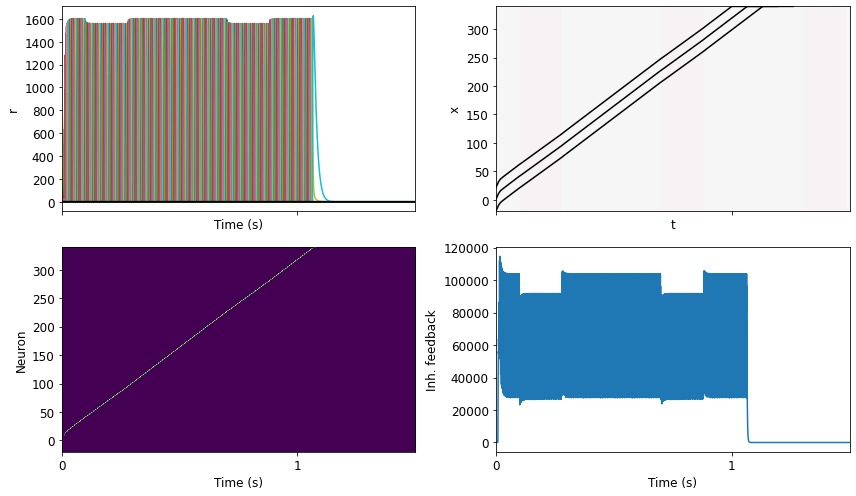

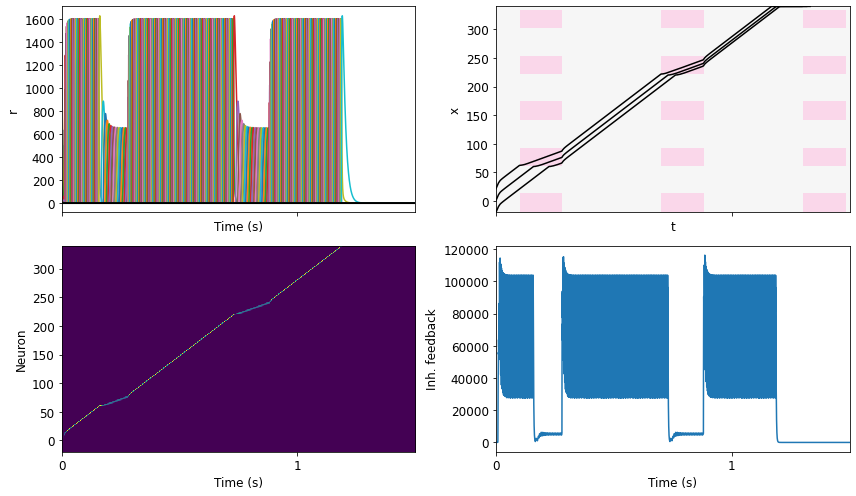

In [4]:
t = np.arange(0, 1.5, DT)
R_0s = [
    np.eye(N)[20, :],
    np.eye(N)[0, :],
    np.eye(N)[40, :],
]

for J_0, W in zip(J_0s, Ws):
    
    rs_all = []
    zs_all = []
    
    for r_0 in R_0s:
        rs, zs = smlt(t, r_0, J_0, J_Z, W, U_FN)
        rs_all.append(rs.copy())
        zs_all.append(zs.copy())

    x_mns = []
    for rs in rs_all:
        ps = np.array([r/np.sum(r) for r in rs])
        x_mn = np.array([RX@p for p in ps])
        x_mns.append(x_mn)

    fig, axs = plt.subplots(2, 2, figsize=(12, 7), tight_layout=True, sharex=True)
    axs = axs.flatten()
    axs[0].plot(t, rs_all[0])
    axs[0].plot(t, rs_all[0][:, 0], c='k', lw=2)
    set_plot(axs[0], x_label='Time (s)', y_label='r')
    
    plot_trj(axs[1], U_FN, W, t=t, xs=x_mns, cscale=.3)
    
    axs[2].matshow(rs_all[0].T, origin='lower', extent=[t[0], t[-1], RX[0], RX[-1]])
    axs[2].set_aspect('auto')
    axs[2].xaxis.tick_bottom()
    set_plot(axs[2], x_label='Time (s)', y_label='Neuron')
    
    axs[3].plot(t, zs_all[0][:, 0])
    set_plot(axs[3], x_label='Time (s)', y_label='Inh. feedback')